In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
from nltk.stem import WordNetLemmatizer
from tfm_module.json_processing import review_df
from sklearn.utils import resample

plt.style.use('ggplot')

lemmatizer = WordNetLemmatizer()

Reviews for training: 18917
                                                text  liked
1  I've taken a lot of spin classes over the year...    1.0
3  Wow!  Yummy, different,  delicious.   Our favo...    1.0
5  I am a long term frequent customer of this est...    0.0
6  Loved this tour! I grabbed a groupon and the p...    1.0
7  Amazingly amazing wings and homemade bleu chee...    1.0


In [2]:
review_df.head()

,text,liked
1,I've taken a lot of spin classes over the year...,1.0
3,"Wow! Yummy, different, delicious. Our favo...",1.0
5,I am a long term frequent customer of this est...,0.0
6,Loved this tour! I grabbed a groupon and the p...,1.0
7,Amazingly amazing wings and homemade bleu chee...,1.0


In [3]:
review_df.iloc[1]['text']

"Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korma.  With 10 different kinds of naan!!!  Don't let the outside deter you (because we almost changed our minds)...go in and try something new!   You'll be glad you did!"

In [4]:
review_df.isnull().sum()

text     0
liked    0
dtype: int64

<Axes: title={'center': 'Review count'}, xlabel='liked'>

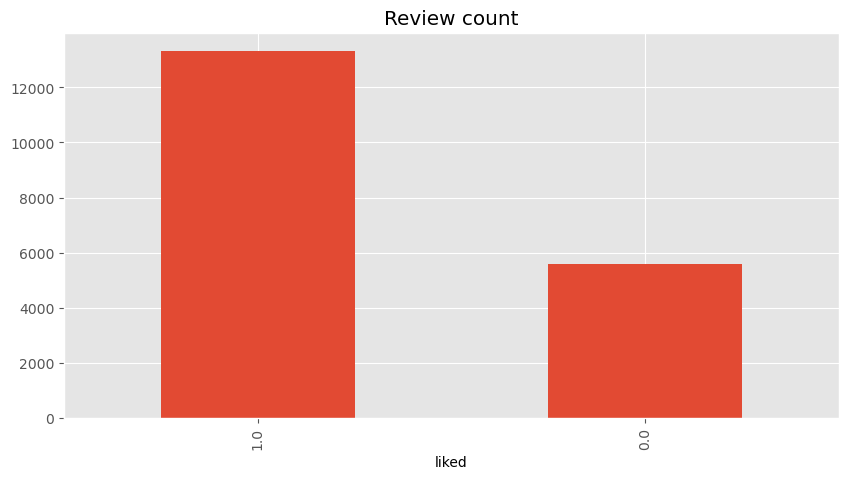

In [5]:
# Revisamos el dataset para posibles sesgos 
review_df['liked'].value_counts().plot(kind='bar', title='Review count', figsize=(10,5))

In [6]:
review_df['liked'].value_counts()

liked
1.0    13328
0.0     5589
Name: count, dtype: int64

In [7]:
# Hacemos undersampling para evitar el sesgo
balance = len(review_df[review_df['liked']==0])

df_majority = review_df[review_df['liked']==1]
df_minority = review_df[review_df['liked']==0]
df_majority_undersampled = resample(df_majority, replace=False, n_samples=balance, random_state=42)
review_df = pd.concat([df_majority_undersampled, df_minority])

In [8]:
review_df['liked'].value_counts()

liked
1.0    5589
0.0    5589
Name: count, dtype: int64

In [9]:
# Reiniciamos el índice manualmente antes del próximo paso
review_df = review_df.reset_index(drop=True)

In [10]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
ps = PorterStemmer()


reviews_procesadas=[]

for i in range(0,len(review_df)):
    text = review_df['text'][i]
    if text:
        Review = re.sub('[^a-zA-Z]',' ',review_df['text'][i])
        Review = Review.lower()
        Review = Review.split()
        Review = [ps.stem(word) for word in Review if word not in set(stopwords.words('english'))]
        Review = ' '.join(Review)
        reviews_procesadas.append(Review)
    
    else:
        reviews_procesadas.append('To discard')


In [11]:
reviews_procesadas[0]

'tanya matt took think tcbi realli creat local follow nice littl shop admit ice cream fall enough flavor keep ice cream snob like happi look someth littl healthier go low cal yogurt everi type top think live music weekend even littl play area kid plu nice chair sit outsid weather permit oh hide fetish ice cream drive wear dark glass one know overal great experi'

In [12]:
# Sustituimos las reviews procesadas en el mismo dataframe de entrenamiento
review_df['text'] = reviews_procesadas
df_modificado = review_df

In [13]:
X = review_df['text']
y = review_df['liked']

In [14]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [16]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', random_state = 12)
clf.fit(X_train_vect,y_train)

LogisticRegression(random_state=12)

In [17]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = clf.predict(X_test_vect)
y_pred[0:10]

array([1., 0., 1., 0., 1., 1., 0., 1., 0., 0.])

In [18]:
accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      1712
         1.0       0.95      0.93      0.94      1642

    accuracy                           0.94      3354
   macro avg       0.94      0.94      0.94      3354
weighted avg       0.94      0.94      0.94      3354



In [19]:
test = "hello this is a great restaurant" 

def pre_p(a):
    p = re.sub('[^a-zA-Z]',' ',a)
    p = p.lower()
    p = p.split()
    p = [ps.stem(word) for word in p if word not in set(stopwords.words('english'))]
    p = ' '.join(p)
    ejemplo = vectorizer.transform([p])
    return ejemplo.toarray()

prediction =clf.predict_proba(pre_p(test))


print(prediction[0][1])


0.881792530638255


In [20]:
# Guardamos el modelo entrenado en un archivo

with open('modelo_entrenado_v1.pk1', 'wb') as file:
    pickle.dump(clf, file)